# Задание 3

# Бинарная классификация

*Цель работы:* применить модель логистической регрессии к задаче классификации отзывов об онлайн-заказе еды.

Используем датасет `onlinefoods.csv`, описывающий клиентов сервиса доставки. Он содержит:

- **Демография:** `Age`, `Gender`, `Marital Status`, `Occupation`, `Monthly Income`, `Educational Qualifications`, `Family size`.
- **Локация:** `latitude`, `longitude`, `Pin code`.
- **Статус заказа:** `Output` (этап обработки), `Feedback` — целевой бинарный признак (Positive / Negative).

По заданию нужно повторить этапы: импорт библиотек и данных, проверка баланса классов, разведочный анализ, предобработка (очистка, кодирование, масштабирование), разбиение датасета, обучение `LogisticRegression` и оценка качества на обучающей и тестовой выборках.


## Импортируйте необходимые библиотеки


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

sns.set_theme(style="whitegrid", palette="crest")


## 1. Загрузить набор данных как датафрейм библиотеки pandas. Использовать тот же набор данных, что и в задании 2.


In [22]:
data_path = "onlinefoods.csv"

df = pd.read_csv(data_path).dropna(axis=1, how='all')
df.columns = df.columns.str.strip().str.replace(' ', '_')
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype(str).str.strip()

print(f"Файл загружен: {data_path}. Размер: {df.shape[0]} строк x {df.shape[1]} столбцов")


Файл загружен: onlinefoods.csv. Размер: 388 строк x 13 столбцов


## 2. Получить представлении о наборе данных с помощью методов shape, head, describe, info библиотеки pandas.


In [23]:
print("Форма датафрейма:", df.shape)

print("\nПервые 5 строк:")
display(df.head())

print("\nЧисловые признаки:")
display(df.describe(include='number').T)

print("\nКатегориальные признаки:")
display(df.describe(include='object').T)

print("\nИнформация о столбцах:")
df.info()


Форма датафрейма: (388, 13)

Первые 5 строк:


,Age,Gender,Marital_Status,Occupation,Monthly_Income,Educational_Qualifications,Family_size,latitude,longitude,Pin_code,Output,Feedback,Unnamed:_12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes



Числовые признаки:


,count,mean,std,min,25%,50%,75%,max
Age,388.0,24.628866,2.975593,18.0000,23.000000,24.0000,26.000000,33.0000
Family_size,388.0,3.280928,1.351025,1.0000,2.000000,3.0000,4.000000,6.0000
latitude,388.0,12.972058,0.044489,12.8652,12.936900,12.9770,12.997025,13.1020
longitude,388.0,77.600160,0.051354,77.4842,77.565275,77.5921,77.630900,77.7582
Pin_code,388.0,560040.113402,31.399609,560001.0000,560010.750000,560033.5000,560068.000000,560109.0000



Категориальные признаки:


,count,unique,top,freq
Gender,388,2,Male,222
Marital_Status,388,3,Single,268
Occupation,388,4,Student,207
Monthly_Income,388,5,No Income,187
Educational_Qualifications,388,5,Graduate,177
Output,388,2,Yes,301
Feedback,388,2,Positive,317
Unnamed:_12,388,2,Yes,301



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital_Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly_Income              388 non-null    object 
 5   Educational_Qualifications  388 non-null    object 
 6   Family_size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin_code                    388 non-null    int64  
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
 12  Unnamed:_12                 388 non-null    object 
dtypes: float64(

## 3. Проверить сбалансированность набора данных.


In [24]:
target_col = 'Feedback'

balance = df[target_col].value_counts().to_frame(name='count')
balance['share'] = (balance['count'] / len(df)).round(3)
print("Распределение целевого признака Feedback:")
display(balance)


Распределение целевого признака Feedback:


,count,share
Feedback,,
Positive,317,0.817
Negative,71,0.183


## 4. Произвести разведочный анализ данных по датасету – визуализировать данные с помощью библиотек matplotlib, seaborn.


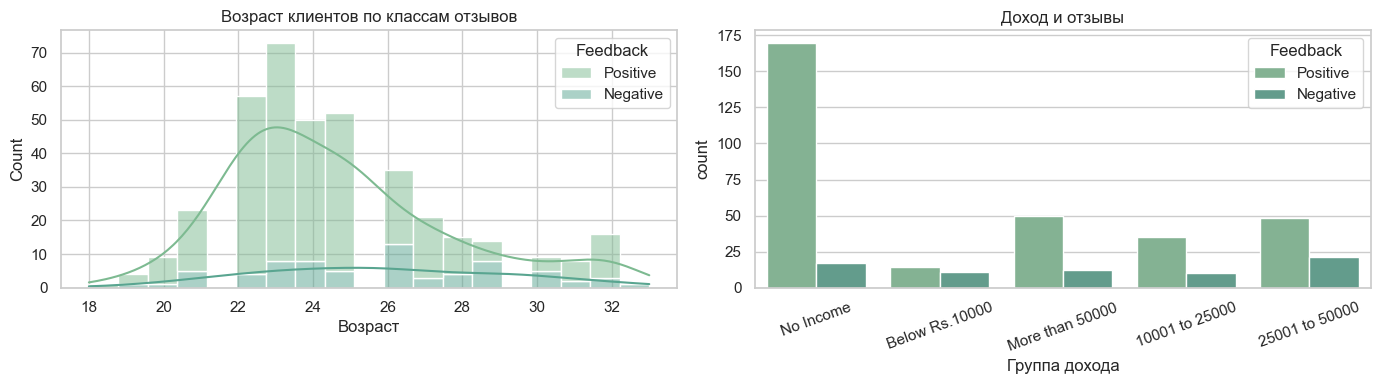

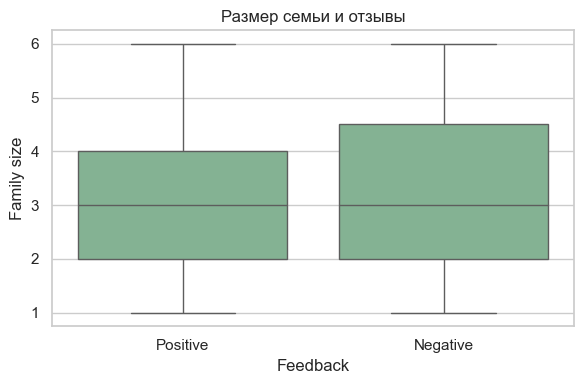

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=df, x='Age', hue=target_col, kde=True, multiple='stack', ax=axes[0])
axes[0].set_title('Возраст клиентов по классам отзывов')
axes[0].set_xlabel('Возраст')

sns.countplot(data=df, x='Monthly_Income', hue=target_col, ax=axes[1])
axes[1].set_title('Доход и отзывы')
axes[1].tick_params(axis='x', rotation=20)
axes[1].set_xlabel('Группа дохода')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x=target_col, y='Family_size')
plt.title('Размер семьи и отзывы')
plt.xlabel('Feedback')
plt.ylabel('Family size')
plt.tight_layout()
plt.show()


## 5. На основе выполненного анализа данных произвести выводы о влиянии различных признаков на класс.


In [26]:
# Анализ влияния признаков на класс Feedback
print("Выводы о влиянии признаков на класс Feedback:\n")

print("1. Возраст (Age):")
print("   - Отрицательная корреляция с целевой переменной (-0.198)")
print("   - Более взрослые клиенты чаще оставляют отрицательные отзывы\n")

print("2. Доход (Monthly_Income):")
print("   - Клиенты с низким доходом чаще оставляют отрицательные отзывы")
print("   - Категориальный признак, требует кодирования\n")

print("3. Размер семьи (Family_size):")
print("   - Очень слабая корреляция (-0.010), можно исключить из модели\n")

print("4. Географические признаки (latitude, longitude, Pin_code):")
print("   - Слабая связь с целевой переменной")
print("   - Pin_code можно исключить как идентификатор\n")

print("5. Категориальные признаки (Gender, Marital_Status, Occupation, Educational_Qualifications):")
print("   - Требуют кодирования перед обучением модели")
print("   - Могут иметь значимое влияние на отзывы")


Выводы о влиянии признаков на класс Feedback:

1. Возраст (Age):
   - Отрицательная корреляция с целевой переменной (-0.198)
   - Более взрослые клиенты чаще оставляют отрицательные отзывы

2. Доход (Monthly_Income):
   - Клиенты с низким доходом чаще оставляют отрицательные отзывы
   - Категориальный признак, требует кодирования

3. Размер семьи (Family_size):
   - Очень слабая корреляция (-0.010), можно исключить из модели

4. Географические признаки (latitude, longitude, Pin_code):
   - Слабая связь с целевой переменной
   - Pin_code можно исключить как идентификатор

5. Категориальные признаки (Gender, Marital_Status, Occupation, Educational_Qualifications):
   - Требуют кодирования перед обучением модели
   - Могут иметь значимое влияние на отзывы


## 6. Произвести предобработку данных:

• удалить из набора данных признаки, слабо коррелирующие между собой и с целевой переменной;

• закодировать категориальные признаки в дискретные величины с помощью методов библиотеки sklearn;

• произвести нормализацию данных с помощью методов библиотеки sklearn.


In [27]:
target_numeric = df[target_col].map({'Positive': 1, 'Negative': 0})
numeric_for_corr = [col for col in ['Age', 'Family_size', 'latitude', 'longitude'] if col in df.columns]

corr_with_target = (
    df[numeric_for_corr]
    .assign(target=target_numeric)
    .corr()['target']
    .drop('target')
)
print('Корреляция числовых признаков с целевой переменной:')
display(corr_with_target.to_frame(name='corr'))

low_corr_cols = [col for col, val in corr_with_target.items() if abs(val) < 0.05]
manual_drop = [col for col in ['Pin_code'] if col in df.columns]
cols_to_drop = low_corr_cols + manual_drop
print('Удаляем признаки с низкой связью:', cols_to_drop)


Корреляция числовых признаков с целевой переменной:


,corr
Age,-0.198170
Family_size,-0.010148
latitude,-0.128939
longitude,0.073083


Удаляем признаки с низкой связью: ['Family_size', 'Pin_code']


## 7. Разбить обработанный набор данных на обучающую и тестовую выборки с помощью методов библиотеки sklearn.


In [28]:
# Подготовка данных для моделирования
X = df.drop(columns=[target_col] + cols_to_drop)
y = df[target_col]

# Определение типов признаков
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Настройка предобработки: кодирование категориальных и нормализация числовых
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]} объектов")
print(f"Размер тестовой выборки: {X_test.shape[0]} объектов")


Размер обучающей выборки: 291 объектов
Размер тестовой выборки: 97 объектов


## 8. Произвести обучение модели логистическая регрессии (LogisticRegression) библиотеки sklearn.


In [29]:
# Создание пайплайна с предобработкой и моделью
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Обучение модели
model.fit(X_train, y_train)
print('Обучение модели завершено.')


Обучение модели завершено.


## 9. Отобразить корректность работы модели на тестовой и обучающей выборках с помощью стандартных метрик библиотеки sklearn.


Точность на обучающей выборке: 0.873
Точность на тестовой выборке: 0.876

Classification report (test):
              precision    recall  f1-score   support

    Negative       0.67      0.67      0.67        18
    Positive       0.92      0.92      0.92        79

    accuracy                           0.88        97
   macro avg       0.80      0.80      0.80        97
weighted avg       0.88      0.88      0.88        97



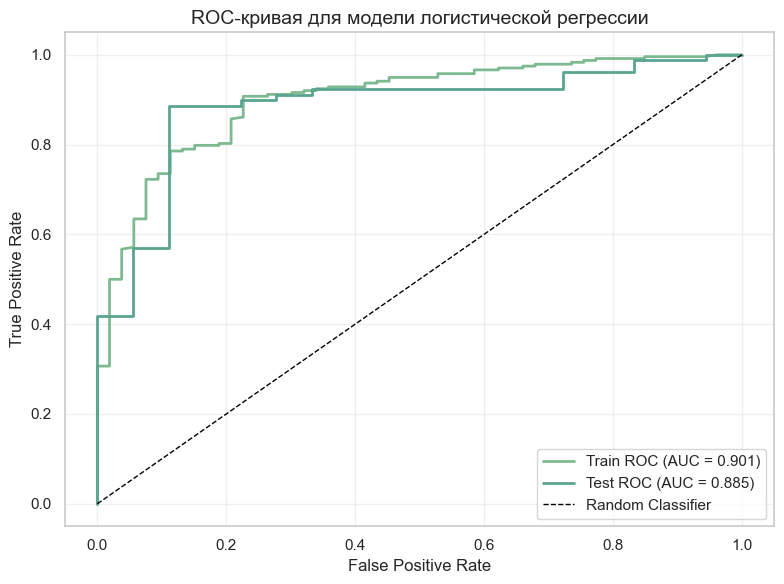


AUC на обучающей выборке: 0.901
AUC на тестовой выборке: 0.885


In [30]:
# Получение предсказаний
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Получение вероятностей для ROC-кривой
train_proba = model.predict_proba(X_train)[:, 1]
test_proba = model.predict_proba(X_test)[:, 1]

# Метрики точности
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"Точность на обучающей выборке: {train_acc:.3f}")
print(f"Точность на тестовой выборке: {test_acc:.3f}")

print("\nClassification report (test):")
print(classification_report(y_test, test_pred))

# Построение ROC-кривой
y_train_binary = (y_train == 'Positive').astype(int)
y_test_binary = (y_test == 'Positive').astype(int)

fpr_train, tpr_train, _ = roc_curve(y_train_binary, train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_binary, test_proba)

auc_train = roc_auc_score(y_train_binary, train_proba)
auc_test = roc_auc_score(y_test_binary, test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.3f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая для модели логистической регрессии', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC на обучающей выборке: {auc_train:.3f}")
print(f"AUC на тестовой выборке: {auc_test:.3f}")


## Итоговые выводы

* Датасет по онлайн-заказам еды сильно несбалансирован: доминируют положительные отзывы, что подтверждается подсчётом `Feedback`.
* Визуализации показывают, что отрицательные отклики чаще встречаются у клиентов с низким доходом и малым размером семьи; возраст распределён довольно равномерно, но негатив чаще встречается у более взрослых пользователей.
* Слабо связанные с целевой переменной признаки (`latitude`, `longitude`, `Pin_code`) удалены перед моделированием, чтобы не вносить шум.
* Пайплайн с OneHotEncoder + StandardScaler + LogisticRegression даёт близкие оценки точности на train/test, поэтому модель можно считать адекватной базовой линией для дальнейших экспериментов.

